# BentoML Example: Keras Fashion MNIST

BentoML is an open-source framework for machine learning **model serving**, aiming to **bridge the gap between Data Science and DevOps.**

Data Scientists can easily package their models trained with any ML framework using BentoMl and reproduce the model for serving in production. BentoML helps with managing packaged models in the BentoML format, and allows DevOps to deploy them as online API serving endpoints or offline batch inference jobs, on any cloud platform.

Before reading this example project, be sure to check out the [Getting started guide](https://github.com/bentoml/BentoML/blob/master/guides/quick-start/bentoml-quick-start-guide.ipynb) to learn about the basic concepts in BentoML.

This notebook demonstrates how to use BentoML to turn a Keras model into a docker image containing a REST API server serving this model, how to use your ML service built with BentoML as a CLI tool, and how to distribute it a pypi package.

![Impression](https://www.google-analytics.com/collect?v=1&tid=UA-112879361-3&cid=555&t=event&ec=keras&ea=keras-fashion-mnist&dt=keras-fashion-mnist)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!pip install -q bentoml tensorflow==1.14.0 numpy matplotlib keras==2.3.1 pillow

In [3]:
from __future__ import absolute_import, division, print_function

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
print("Tensorflow Version: %s" % tf.__version__)

import keras
print("Keras Version: %s" % keras.__version__)

import bentoml
print("BentoML Version: %s" % bentoml.__version__)

Tensorflow Version: 1.14.0
Keras Version: 2.3.1


Using TensorFlow backend.


BentoML Version: 0.8.3+47.g7af5a8f


## Load Fashion MNIST dataset

In [4]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

Each image is mapped to a single label. Since the class names are not included with the dataset, store them here to use later when plotting the images:

In [5]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Preprocess the data

The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:

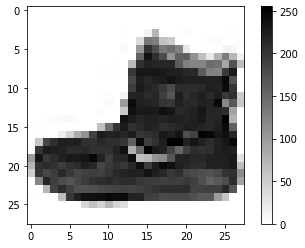

In [6]:
plt.figure()
plt.imshow(train_images[0], cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

We should scale these values to a range of 0 to 1 before feeding to the neural network model. For this, we divide the values by 255. It's important that the *training set* and the *testing set* are preprocessed in the same way:

In [7]:
train_images = train_images / 255.0
test_images = test_images / 255.0

Display the first 25 images from the training set and display the class name below each image. Verify that the data is in the correct format and we're ready to build and train the network.

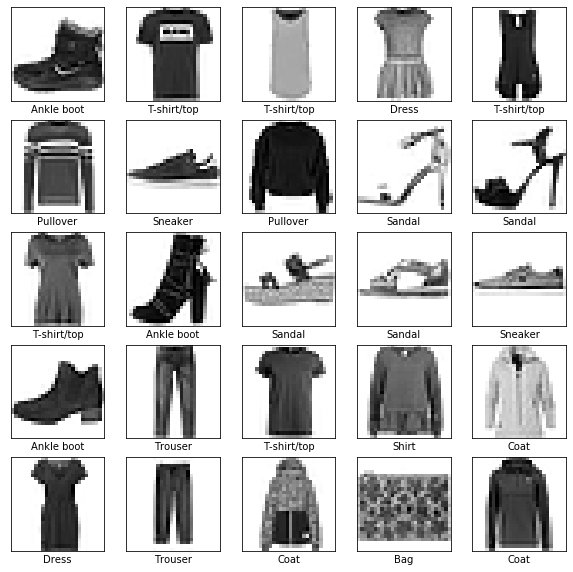

In [8]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [9]:
# Reshaping the images so that our model can accept it
train_images  = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

## Build the model

In [10]:
model = keras.Sequential()
# Must define the input shape in the first layer of the neural network
model.add(keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1))) 
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(10, activation='softmax'))
# Take a look at the model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)            

## Compile the model

In [11]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Train the model

In [12]:
model.fit(train_images, train_labels, batch_size=64, epochs=5)


Epoch 1/5
60000/60000 [==============================] - 7s 117us/step - loss: 0.5991 - accuracy: 0.7797
Epoch 2/5
60000/60000 [==============================] - 6s 97us/step - loss: 0.4139 - accuracy: 0.8503
Epoch 3/5
60000/60000 [==============================] - 6s 98us/step - loss: 0.3687 - accuracy: 0.8659
Epoch 4/5
60000/60000 [==============================] - 6s 95us/step - loss: 0.3423 - accuracy: 0.8751
Epoch 5/5
60000/60000 [==============================] - 6s 98us/step - loss: 0.3203 - accuracy: 0.8814


## Evaluate model accuracy

In [13]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

10000/10000 [==============================] - 1s 62us/step
Test accuracy: 0.8956000208854675


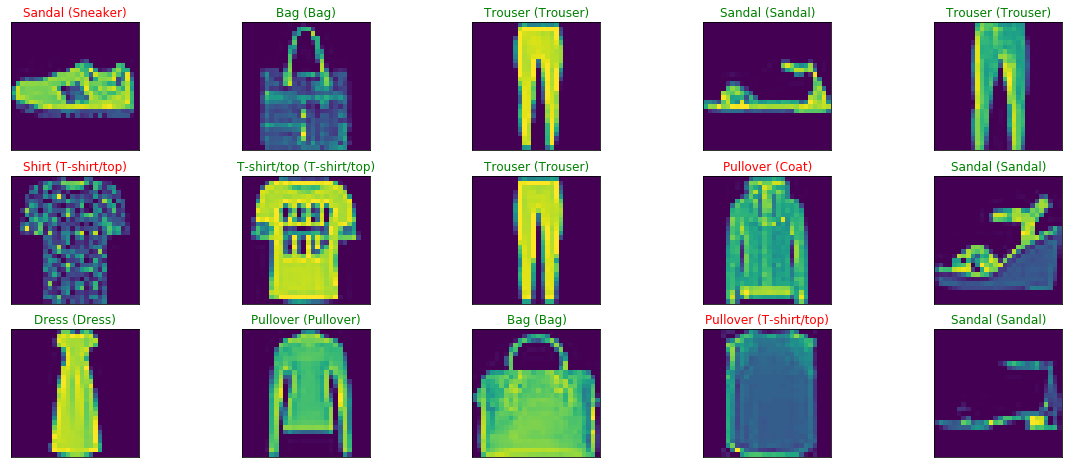

In [14]:
y_hat = model.predict_classes(test_images)

# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(test_images.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(test_images[index]))
    predict_index = y_hat[index]
    true_index = test_labels[index]
    # Set the title for each image
    ax.set_title("{} ({})".format(class_names[predict_index], 
                                  class_names[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

## Predict on a single image

Let's first see the test image and and its label:

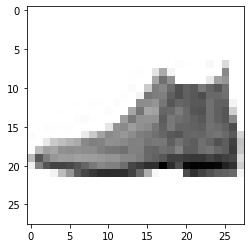

Class: Ankle boot


In [15]:
plt.imshow(test_images[0].squeeze(-1), cmap=plt.cm.binary)
plt.show()
print('Class:', class_names[test_labels[0]])

In [16]:
pred_idx = model.predict_classes(np.expand_dims(test_images[0], 0))[0]
print('Prediction:', class_names[pred_idx])

Prediction: Ankle boot


## Define BentoService for model serving

In [17]:
%%writefile keras_fashion_mnist.py

import numpy as np
from PIL import Image
from bentoml import api, artifacts, env, BentoService
from bentoml.frameworks.keras import KerasModelArtifact
from bentoml.adapters import ImageInput

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

@env(pip_packages=['keras==2.3.1', 'tensorflow==1.14.0', 'pillow', 'numpy'])
@artifacts([KerasModelArtifact('classifier')])
class KerasFashionMnistService(BentoService):
        
    @api(input=ImageInput(pilmode='L'))
    def predict(self, imgs):
        inputs = []
        for img in imgs:
            img = Image.fromarray(img).resize((28, 28))
            img = np.array(img.getdata()).reshape((28, 28, 1))
            inputs.append(img)
        inputs = np.stack(inputs)
        class_idxs = self.artifacts.classifier.predict_classes(inputs)
        return [class_names[class_idx] for class_idx in class_idxs]

Overwriting keras_fashion_mnist.py


## Save BentoService to file archive

In [18]:
# 1) import the custom BentoService defined above
from keras_fashion_mnist import KerasFashionMnistService

# 2) `pack` it with required artifacts
mnist_svc = KerasFashionMnistService()
mnist_svc.pack('classifier', model)

# 3) save your BentoSerivce to file archive
saved_path = mnist_svc.save()

[2020-08-04 11:52:26,769] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.

[2020-08-04 11:52:40,069] INFO - Detect BentoML installed in development model, copying local BentoML module file to target saved bundle path
running sdist
running egg_info
writing BentoML.egg-info/PKG-INFO
writing dependency_links to BentoML.egg-info/dependency_links.txt
writing entry points to BentoML.egg-info/entry_points.txt
writing requirements to BentoML.egg-info/requires.txt
writing top-level names to BentoML.egg-info/top_level.txt
reading manifest file 'BentoML.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'


no previously-included directories found matching 'e2e_tests'
no previously-included directories found matching 'tests'
no previously-included directories found matching 'benchmark'


writing manifest file 'BentoML.egg-info/SOURCES.txt'
running check
creating BentoML-0.8.3+47.g7af5a8f
creating BentoML-0.8.3+47.g7af5a8f/BentoML.egg-info
creating BentoML-0.8.3+47.g7af5a8f/bentoml
creating BentoML-0.8.3+47.g7af5a8f/bentoml/adapters
creating BentoML-0.8.3+47.g7af5a8f/bentoml/artifact
creating BentoML-0.8.3+47.g7af5a8f/bentoml/cli
creating BentoML-0.8.3+47.g7af5a8f/bentoml/clipper
creating BentoML-0.8.3+47.g7af5a8f/bentoml/configuration
creating BentoML-0.8.3+47.g7af5a8f/bentoml/configuration/__pycache__
creating BentoML-0.8.3+47.g7af5a8f/bentoml/handlers
creating BentoML-0.8.3+47.g7af5a8f/bentoml/marshal
creating BentoML-0.8.3+47.g7af5a8f/bentoml/saved_bundle
creating BentoML-0.8.3+47.g7af5a8f/bentoml/server
creating BentoML-0.8.3+47.g7af5a8f/bentoml/utils
creating BentoML-0.8.3+47.g7af5a8f/bentoml/yatai
creating BentoML-0.8.3+47.g7af5a8f/bentoml/yatai/client
creating BentoML-0.8.3+47.g7af5a8f/bentoml/yatai/deployment
creating BentoML-0.8.3+47.g7af5a8f/bentoml/yatai/dep

## Load saved BentoService

bentoml.load is the API for loading a BentoML packaged model in python:

In [37]:
svc = bentoml.load(saved_path)
svc.predict([test_images[0].squeeze(-1)])

[2020-08-04 11:40:53,595] WARNING - Saved BentoService bundle version mismatch: loading BentoService bundle create with BentoML version 0.8.3, but loading from BentoML version 0.8.3+47.g7af5a8f
[2020-08-04 11:40:53,596] WARNING - Module `keras_fashion_mnist` already loaded, using existing imported module.
[2020-08-04 11:40:53,597] WARNING - `load` on a 'packed' artifact may lead to unexpected behaviors
[2020-08-04 11:40:53,598] WARNING - `load` an artifact multiple times may lead to unexpected behaviors
[2020-08-04 11:40:54,787] WARNING - `pack` an artifact multiple times may lead to unexpected behaviors


['Ankle boot']

## Launch inference job from CLI

BentoML cli supports loading and running a packaged model from CLI. With the DataframeInput adapter, the CLI command supports reading input Dataframe data from CLI argument or local csv or json files:

In [1]:
!bentoml run KerasFashionMnistService:latest predict --input=sample_image.png

[2020-08-04 11:41:38,313] INFO - Getting latest version KerasFashionMnistService:20200804114025_051A42
[2020-08-04 11:41:39,278] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
[2020-08-04 11:41:39,312] WARNING - Saved BentoService bundle version mismatch: loading BentoService bundle create with BentoML version 0.8.3, but loading from BentoML version 0.8.3+47.g7af5a8f
[2020-08-04 11:41:40,483] WARNING - Pillow package does not exist in the current python session
Using TensorFlow backend.
2020-08-04 11:41:40.595206: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcuda.so.1
2020-08-04 11:41:40.612103: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1005] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

## REST API Model Serving


To start a REST API model server with the BentoService saved above, use the bentoml serve command:

In [2]:
!bentoml serve KerasFashionMnistService:latest --enable-microbatch

[2020-08-04 11:41:58,836] INFO - Getting latest version KerasFashionMnistService:20200804114025_051A42
[2020-08-04 11:41:58,836] INFO - Starting BentoML API server in development mode..
[2020-08-04 11:42:00,073] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
[2020-08-04 11:42:00,105] WARNING - Saved BentoService bundle version mismatch: loading BentoService bundle create with BentoML version 0.8.3, but loading from BentoML version 0.8.3+47.g7af5a8f
[2020-08-04 11:42:01,278] WARNING - Pillow package does not exist in the current python session
Using TensorFlow backend.
2020-08-04 11:42:01.316008: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcuda.so.1
2020-08-04 11:42:01.331941: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1005] successf

If you are running this notebook from Google Colab, you can start the dev server with `--run-with-ngrok` option, to gain acccess to the API endpoint via a public endpoint managed by [ngrok](https://ngrok.com/):

In [ ]:
!bentoml serve KerasFashionMnistService:latest --run-with-ngrok

Test sending request to API Server from terminal:

```bash
curl -X POST "http://127.0.0.1:5000/predict" -F image=@sample_image.png
```

or:

```bash
curl -X POST "http://127.0.0.1:5000/predict" -H "Content-Type: image/png" --data-binary @sample_image.png
```

## Containerize model server with Docker


One common way of distributing this model API server for production deployment, is via Docker containers. And BentoML provides a convenient way to do that.

Note that docker is **not available in Google Colab**. You will need to download and run this notebook locally to try out this containerization with docker feature.

If you already have docker configured, simply run the follow command to product a docker container serving the IrisClassifier prediction service created above:

In [19]:
!bentoml containerize KerasFashionMnistService:latest

sha256:fc22721b34f05b257dd9fc395ca9ff56cd04db9edd27df04449f9c61eaffc10c


In [21]:
!docker run -p 5000:5000 kerasfashionmnistservice

[2020-08-04 04:01:46,065] INFO - Starting BentoML API server in production mode..
[2020-08-04 04:01:46,488] INFO - Running micro batch service on :5000
[2020-08-04 04:01:46 +0000] [1] [INFO] Starting gunicorn 20.0.4
[2020-08-04 04:01:46 +0000] [1] [INFO] Listening at: http://0.0.0.0:53179 (1)
[2020-08-04 04:01:46 +0000] [1] [INFO] Using worker: sync
[2020-08-04 04:01:46 +0000] [12] [INFO] Starting gunicorn 20.0.4
[2020-08-04 04:01:46 +0000] [12] [INFO] Listening at: http://0.0.0.0:5000 (12)
[2020-08-04 04:01:46 +0000] [12] [INFO] Using worker: aiohttp.worker.GunicornWebWorker
[2020-08-04 04:01:46 +0000] [13] [INFO] Booting worker with pid: 13
[2020-08-04 04:01:46 +0000] [14] [INFO] Booting worker with pid: 14
[2020-08-04 04:01:46,522] WARNING - Using BentoML not from official PyPI release. In order to find the same version of BentoML when deplying your BentoService, you must set the 'core/bentoml_deploy_version' config to a http/git location of your BentoML fork, e.g.: 'bentoml_deploy_

# Deployment Options

If you are at a small team with limited engineering or DevOps resources, try out automated deployment with BentoML CLI, currently supporting AWS Lambda, AWS SageMaker, and Azure Functions:
- [AWS Lambda Deployment Guide](https://docs.bentoml.org/en/latest/deployment/aws_lambda.html)
- [AWS SageMaker Deployment Guide](https://docs.bentoml.org/en/latest/deployment/aws_sagemaker.html)
- [Azure Functions Deployment Guide](https://docs.bentoml.org/en/latest/deployment/azure_functions.html)

If the cloud platform you are working with is not on the list above, try out these step-by-step guide on manually deploying BentoML packaged model to cloud platforms:
- [AWS ECS Deployment](https://docs.bentoml.org/en/latest/deployment/aws_ecs.html)
- [Google Cloud Run Deployment](https://docs.bentoml.org/en/latest/deployment/google_cloud_run.html)
- [Azure container instance Deployment](https://docs.bentoml.org/en/latest/deployment/azure_container_instance.html)
- [Heroku Deployment](https://docs.bentoml.org/en/latest/deployment/heroku.html)

Lastly, if you have a DevOps or ML Engineering team who's operating a Kubernetes or OpenShift cluster, use the following guides as references for implementating your deployment strategy:
- [Kubernetes Deployment](https://docs.bentoml.org/en/latest/deployment/kubernetes.html)
- [Knative Deployment](https://docs.bentoml.org/en/latest/deployment/knative.html)
- [Kubeflow Deployment](https://docs.bentoml.org/en/latest/deployment/kubeflow.html)
- [KFServing Deployment](https://docs.bentoml.org/en/latest/deployment/kfserving.html)
- [Clipper.ai Deployment Guide](https://docs.bentoml.org/en/latest/deployment/clipper.html)